In [2]:
import os,sys,signal
import math

import pickle
import numpy as np                                       # fast vectors and matrices
import matplotlib.pyplot as plt                          # plotting

import musicnet

from time import time

from sklearn.metrics import average_precision_score

os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'   # see issue #152
os.environ['CUDA_VISIBLE_DEVICES']='0'

import torch
from torch.nn.functional import conv1d, mse_loss
import torch.nn.functional as F
import torch.nn as nn

if torch.cuda.is_available():
    device = "cuda:0"
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [3]:
# Network Parameters
epochs = 1000
train_size = 100000
test_size = 50000

lr = 0.0001
momentum = .95

pitch_shift = 0
jitter = 0.
num_workers = 10
sequence = 1

# lvl1 convolutions are shared between regions
m = 128
k = 512              # lvl1 nodes
n_fft = 4096              # lvl1 receptive field
window = 16384 # total number of audio samples?
stride = 512
batch_size = 100

regions = 1 + (window - n_fft)//stride

def worker_init(args):
    signal.signal(signal.SIGINT, signal.SIG_IGN) # ignore signals so parent can handle them
    np.random.seed(os.getpid() ^ int(time())) # approximately random seed for workers
kwargs = {'num_workers': num_workers, 'pin_memory': True, 'worker_init_fn': worker_init}

In [4]:
# function for returning scientific notation in a plot
def fmt(x, pos):
    a, b = '{:.0e}'.format(x).split('e')
    b = int(b)
    return fr'${a} \times 10^{{{b}}}$'

In [5]:
result_dict = {'loss_history_train': [],
               'avgp_history_train': [],
               'loss_history_test': [],
               'avgp_history_test': [],
               'parameters': {}}

result_dict['parameters']['train_size'] = train_size
result_dict['parameters']['test_size'] = test_size
result_dict['parameters']['lr'] = lr
result_dict['parameters']['pitch_shift'] = pitch_shift
result_dict['parameters']['jitter'] = jitter

# Preparing Dataset

In [6]:
start = time()
root = './data/'
train_set = musicnet.MusicNet(root=root, epoch_size=train_size,sequence=sequence
                              , train=True, download=True, refresh_cache=False, 
                              window=window, mmap=False, pitch_shift=pitch_shift, jitter=jitter)
test_set = musicnet.MusicNet(root=root, train=False, download=True,sequence=sequence
                             , refresh_cache=False, window=window, epoch_size=test_size, mmap=False)
print("Data loaded, time used = {:2.2f} seconds".format(time()-start))

train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=batch_size,**kwargs)
test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,**kwargs)

Data loaded, time used = 28.93 seconds


# Defining Models

In [7]:
Loss = torch.nn.MSELoss()
def L(yhatvar,y):
    return Loss(yhatvar,y) * 128/2

In [8]:
class Model(torch.nn.Module):
    def __init__(self, avg=.9998):
        super(Model, self).__init__()          
        # Creating Layers
        self.linear1 = torch.nn.Linear(regions*k, k, bias=False)
        self.linear2 = torch.nn.Linear(k, m, bias=False)
        self.conv1d = torch.nn.Conv1d(1,k,n_fft,stride)
        
        wscale1 = 10e-3
        wscale2 = 10e-3
        # initialize filters for Fourier Transform
        torch.nn.init.normal_(self.conv1d.weight, std=wscale1)
        
        # initialize other network weights
        torch.nn.init.normal_(self.linear1.weight, std=wscale2)
        torch.nn.init.normal_(self.linear2.weight, std=wscale2)
        
        self.avg = avg
        
    def forward(self,x):
        zx = torch.log(1 + torch.relu(self.conv1d(x[:,None,:])))
        z2 = self.linear1(zx.view(x.data.size()[0],regions*k))
        y = self.linear2(torch.relu(z2))
        return y

In [9]:
model = Model()
model.to(device)

Model(
  (linear1): Linear(in_features=12800, out_features=512, bias=False)
  (linear2): Linear(in_features=512, out_features=128, bias=False)
  (conv1d): Conv1d(1, 512, kernel_size=(4096,), stride=(512,))
)

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = SWA(base_opt, swa_start=0, swa_freq=1, swa_lr=0.000001)

try:
    with train_set, test_set:
        print("epoch\ttrain loss\ttest loss\ttrain avg\ttest avg\ttime\tutime")
        for e in range(epochs):
            yground = torch.Tensor(batch_size*len(train_loader), m) # what not do this together with loss
            yhat = torch.Tensor(batch_size*len(train_loader), m)
            avgp, loss_e = 0.,0
            t = time()
            for i, (x,y) in enumerate(train_loader):
                print(f"training {i}/{len(train_loader)} batches", end = '\r')
                optimizer.zero_grad()

                # making x and y into pytorch dealable format
                x = x.to(device, non_blocking=True)
                y = y.to(device, non_blocking=True)
                yhatvar = model(x)
                loss = L(yhatvar,y)
                loss.backward()
                loss_e += loss.item() #getting the number

                yground[i*batch_size:(i+1)*batch_size] = y.data
                yhat[i*batch_size:(i+1)*batch_size] = yhatvar.data

                optimizer.step()
            avgp = average_precision_score(yground.cpu().flatten(),yhat.cpu().flatten())  

            result_dict['loss_history_train'].append(loss_e/len(train_loader))
            result_dict['avgp_history_train'].append(avgp)   
            t1 = time()
            avgp, loss_e = 0.,0.           
#             optimizer.swap_swa_sgd() # change to average weight

            # For testing
            yground = torch.Tensor(batch_size*len(test_loader), m) # what not do this together with loss
            yhat = torch.Tensor(batch_size*len(test_loader), m)

            for i, (x_test,y_test) in enumerate(test_loader):
                print(f"testing {i}/{len(test_loader)} batches", end = '\r')
                x_test = x_test.to(device)
                y_test = y_test.to(device)
                yhatvar = model(x_test)
                loss_e += L(yhatvar, y_test).item() #getting the number

                yground[i*batch_size:(i+1)*batch_size] = y_test.data
                yhat[i*batch_size:(i+1)*batch_size] = yhatvar.data
            avgp = average_precision_score(yground.cpu().flatten(),yhat.cpu().flatten())
            result_dict['loss_history_test'].append(loss_e/len(test_loader))
            result_dict['avgp_history_test'].append(avgp)
            print('{}\t{:2f}\t{:2f}\t{:2f}\t{:2f}\t{:2.1f}\t{:2.1f}'.\
                  format(e,
                         result_dict['loss_history_train'][-1],result_dict['loss_history_test'][-1],
                         result_dict['avgp_history_train'][-1],result_dict['avgp_history_test'][-1],
                         time()-t, time()-t1))

except KeyboardInterrupt:
    print('Graceful Exit')
else:
    print("Finsihed")

epoch	train loss	test loss	train avg	test avg	time	utime
0	1.112241	0.794501	0.376076	0.462410	81.1	17.1
1	0.973189	0.735573	0.502621	0.525270	69.9	20.6
2	0.924780	0.715425	0.544373	0.556845	66.3	20.2
3	0.897898	0.695997	0.569218	0.579360	71.7	18.9
4	0.878610	0.688575	0.585480	0.587672	70.8	21.7
5	0.867031	0.677755	0.594027	0.598828	65.4	20.0
6	0.858902	0.672949	0.604283	0.606229	74.4	21.7
7	0.851175	0.663267	0.609596	0.615577	77.5	19.4
8	0.843525	0.665190	0.615584	0.616438	76.0	32.6
9	0.839874	0.657397	0.621176	0.620521	64.0	19.9
10	0.833135	0.651628	0.626042	0.627267	77.7	19.3
11	0.827480	0.654173	0.630319	0.627640	74.6	30.5
12	0.832720	0.652977	0.630770	0.628701	65.6	19.3
13	0.820113	0.646471	0.634733	0.634498	76.0	18.6
14	0.821437	0.647921	0.637280	0.631525	69.3	25.8
15	0.817252	0.641425	0.641059	0.636743	63.7	19.6
16	0.813718	0.641884	0.642935	0.641780	76.3	23.8
17	0.807386	0.634658	0.647079	0.645725	62.8	18.1
18	0.807288	0.640216	0.648798	0.641214	71.3	20.8
19	0.806528	0.636801	0

165	0.684844	0.566558	0.726372	0.696713	70.4	20.4
166	0.685453	0.567298	0.725499	0.696344	72.2	22.2
167	0.686137	0.566071	0.726189	0.697717	68.4	25.7
168	0.685851	0.565461	0.727538	0.697806	72.7	20.4
169	0.687855	0.562745	0.723570	0.698456	78.7	22.3
170	0.685401	0.565757	0.727034	0.700086	66.2	23.5
171	0.683722	0.562020	0.725397	0.698301	66.9	21.5
172	0.682827	0.566311	0.727540	0.695849	78.9	23.2
173	0.686000	0.566323	0.725424	0.694534	68.3	27.9
174	0.685274	0.566531	0.726993	0.695345	63.6	20.6
175	0.687809	0.563729	0.726740	0.696633	71.9	20.6
176	0.684993	0.564309	0.726517	0.698106	80.7	33.8
177	0.682569	0.564231	0.727100	0.697212	61.4	20.1
178	0.682735	0.562357	0.728250	0.698448	68.3	21.2
179	0.684376	0.562747	0.725435	0.698716	76.8	21.4
180	0.685487	0.562813	0.727862	0.698154	66.9	25.6
181	0.679098	0.564906	0.729565	0.696813	68.5	21.9
182	0.678625	0.565564	0.730749	0.695775	81.0	28.4
183	0.681887	0.558976	0.727267	0.696246	62.0	18.8
184	0.680735	0.559177	0.728357	0.699148	81.2	20.9


329	0.654007	0.554035	0.745288	0.701731	65.7	19.3
330	0.655603	0.551781	0.744282	0.702331	69.2	17.0
331	0.654317	0.554719	0.744533	0.697444	80.8	31.3
332	0.652577	0.550583	0.745347	0.705963	55.8	15.5
333	0.651320	0.554124	0.745883	0.703260	79.3	19.4
334	0.654491	0.553792	0.744306	0.702343	86.5	33.8
335	0.652641	0.555473	0.745826	0.695147	65.8	19.9
336	0.649593	0.550955	0.748677	0.704929	79.0	21.5
337	0.651691	0.551957	0.746396	0.702212	75.2	21.4
338	0.653648	0.553924	0.746178	0.704855	66.0	23.8
339	0.650336	0.551754	0.747490	0.702272	69.4	19.6
340	0.653356	0.549098	0.745812	0.705862	82.2	20.4
341	0.652201	0.549849	0.746659	0.706024	57.2	17.7
342	0.653806	0.556258	0.745287	0.701202	73.9	19.1
343	0.652665	0.551975	0.747183	0.703241	74.6	21.0
344	0.651084	0.551738	0.747262	0.705119	61.9	19.3
345	0.651955	0.554486	0.745133	0.703890	75.6	20.8
346	0.649166	0.552703	0.747932	0.702964	65.8	21.8
347	0.647977	0.550405	0.748620	0.704210	78.3	36.6
348	0.650740	0.552815	0.746632	0.701421	62.8	20.5


493	0.635335	0.551393	0.756044	0.701954	69.7	18.1
494	0.634849	0.550159	0.755833	0.705087	73.4	15.3
495	0.637972	0.551216	0.755171	0.704307	67.8	20.1
496	0.637959	0.547786	0.756358	0.706920	59.2	15.7
497	0.637284	0.548631	0.756259	0.707198	74.4	20.6
498	0.636573	0.553313	0.756300	0.702677	82.4	39.6
499	0.639188	0.547904	0.754042	0.703303	62.0	21.3
500	0.636582	0.545541	0.756880	0.706224	73.6	21.7
501	0.636200	0.546021	0.755688	0.705634	78.4	37.9
502	0.637273	0.551358	0.755363	0.702604	63.4	20.8
503	0.636622	0.554401	0.755819	0.700600	78.4	21.4
504	0.638086	0.551407	0.755815	0.703172	80.6	35.8
505	0.637046	0.547812	0.755908	0.706487	61.8	20.5
506	0.634990	0.553690	0.756424	0.703897	80.0	21.3
507	0.637155	0.548987	0.754624	0.704998	78.5	33.0
508	0.633758	0.555179	0.758385	0.701368	61.9	19.7
509	0.638345	0.550103	0.754704	0.704562	78.8	21.6
510	0.640357	0.552900	0.754671	0.705634	77.7	29.1
511	0.635715	0.539822	0.755639	0.710124	62.9	19.4
512	0.635138	0.544459	0.756141	0.706772	84.5	21.1


657	0.628870	0.546239	0.761758	0.703674	48.6	11.2
658	0.627248	0.544055	0.762515	0.704041	52.5	18.7
659	0.626512	0.542980	0.762638	0.706832	41.4	10.9
660	0.626572	0.543465	0.763268	0.707805	51.2	11.4
661	0.626976	0.549101	0.761652	0.703688	46.9	10.8
662	0.626208	0.551934	0.762473	0.703311	36.2	10.4
663	0.625656	0.545885	0.764325	0.706096	48.5	10.9
664	0.625478	0.544680	0.762096	0.704697	48.0	11.2
665	0.624128	0.543230	0.763716	0.707531	46.7	12.7
666	0.625084	0.547959	0.763789	0.704833	39.6	11.0
667	0.623121	0.548181	0.761998	0.706482	47.2	11.2
668	0.624810	0.550065	0.763121	0.701938	48.1	10.9
669	0.623074	0.543763	0.764101	0.706591	42.4	12.0
670	0.626120	0.544763	0.762096	0.705796	46.8	10.8
671	0.625461	0.545197	0.763317	0.708301	49.6	11.2
672	0.623404	0.549755	0.764366	0.704094	46.8	10.9
673	0.629752	0.546886	0.760736	0.703894	36.4	10.6
674	0.625340	0.545456	0.763950	0.706593	48.6	10.8
675	0.623590	0.550103	0.765044	0.706403	46.5	11.0
676	0.626493	0.554132	0.763009	0.698341	53.9	20.2


821	0.618308	0.541567	0.766243	0.706395	58.5	13.2
822	0.619039	0.545235	0.765126	0.703530	56.8	11.5
823	0.614386	0.545010	0.769651	0.704453	45.5	13.0
824	0.616021	0.546231	0.767103	0.705572	58.5	13.2
825	0.618463	0.542828	0.767623	0.708082	58.7	13.4
826	0.618083	0.546409	0.766290	0.704446	58.8	13.3
827	0.618960	0.547790	0.767628	0.700411	45.9	12.2
828	0.615359	0.542627	0.768479	0.706152	58.6	13.2
829	0.615681	0.547243	0.767623	0.705573	58.5	13.1
830	0.617572	0.550747	0.767896	0.700481	58.8	13.3
831	0.618550	0.542428	0.767855	0.704498	49.3	10.6
832	0.614308	0.542746	0.767112	0.704273	53.5	13.2
833	0.618730	0.547647	0.767216	0.707163	58.6	13.2
834	0.612124	0.542418	0.769379	0.706473	59.0	13.4
835	0.620208	0.543779	0.767410	0.706170	51.3	13.2
836	0.617067	0.546304	0.768876	0.704472	52.5	12.7
837	0.617781	0.546040	0.767572	0.705335	58.8	13.4
838	0.615250	0.542999	0.769824	0.708724	58.6	13.2
839	0.618696	0.543418	0.768002	0.704234	49.3	13.3
840	0.616177	0.545875	0.768507	0.703473	56.0	10.8


(0.3, 0.8)

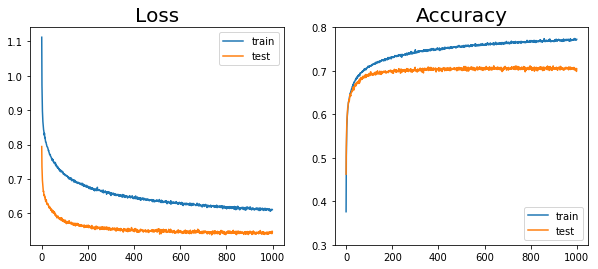

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))

ax[0].plot(result_dict['loss_history_train'])
ax[0].plot(result_dict['loss_history_test'])
ax[0].legend(['train', 'test'])
ax[0].set_title('Loss', size=20)

ax[1].plot(result_dict['avgp_history_train'])
ax[1].plot(result_dict['avgp_history_test'])
ax[1].legend(['train', 'test'])
ax[1].set_title('Accuracy', size=20)
ax[1].set_ylim(0.3,0.80)

# Mir_Eval stats

In [14]:
print('AvgP\tP\tR\tAcc\tETot\tESub\tEmiss\tEfa')
Accavg = 0
Etotavg = 0
for songid in test_set.rec_ids:
    Y_pred, Y_true = musicnet.get_piano_roll(songid, test_set, model, device,
                                             window=window, m=m, stride=-1)
    Yhatpred = Y_pred > 0.4
    _,_,_,Acc,Etot = musicnet.get_mir_accuracy(Y_pred, Y_true, m=m)
    Accavg += Acc
    Etotavg += Etot

AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
76.47	73.16	74.83	0.59	0.41	0.12	0.13	0.16
79.27	73.22	76.81	0.60	0.42	0.09	0.14	0.19
47.16	54.55	44.64	0.33	0.76	0.17	0.39	0.20
64.35	57.79	73.57	0.48	0.70	0.10	0.17	0.44
78.61	69.65	82.67	0.61	0.42	0.11	0.06	0.25
76.99	71.39	72.67	0.56	0.42	0.14	0.13	0.15
67.83	69.65	61.70	0.49	0.49	0.16	0.23	0.11
68.27	66.66	65.84	0.50	0.53	0.14	0.20	0.19
75.33	71.75	69.94	0.55	0.48	0.10	0.20	0.18
71.61	68.61	73.55	0.55	0.48	0.13	0.14	0.21


In [15]:
print('Average Accuracy: \t{:2.2f}\nAverage Error: \t\t{:2.2f}'
      .format(Accavg/len(test_set.rec_ids)*100, Etotavg/len(test_set.rec_ids)*100))

Average Accuracy: 	52.42
Average Error: 		51.13


# Saving weights and results

In [12]:
torch.save(model.state_dict(), './weights/three-layer-e2e')
with open('./result_dict/three-layer-e2e', 'wb') as f:
    pickle.dump(result_dict, f)